# Trénovanie modelu na základe DST indexu 6 h dozadu, predikcia súčasnej hodnoty

In [ ]:
# inštalovanie knižníc
!pip install pyarrow
!pip install keras
#!pip install --upgrade tensorflow
#!pip install --upgrade tensorflow-gpu

In [ ]:
#!pip install tensorflow==2.14.1

# Importovanie knižníc

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model


from scipy.special import expit, logit

from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

2024-05-16 10:27:35.059687: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Načítanie dát a určenie predikovanej hodnoty

In [2]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
features = ['time1',
            'DST']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicted_label = 'DST'

y_col='DST'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[y_col].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[y_col].values.copy()
y_test = test[y_col].values.copy()
X_test = test[y_col].values.copy()

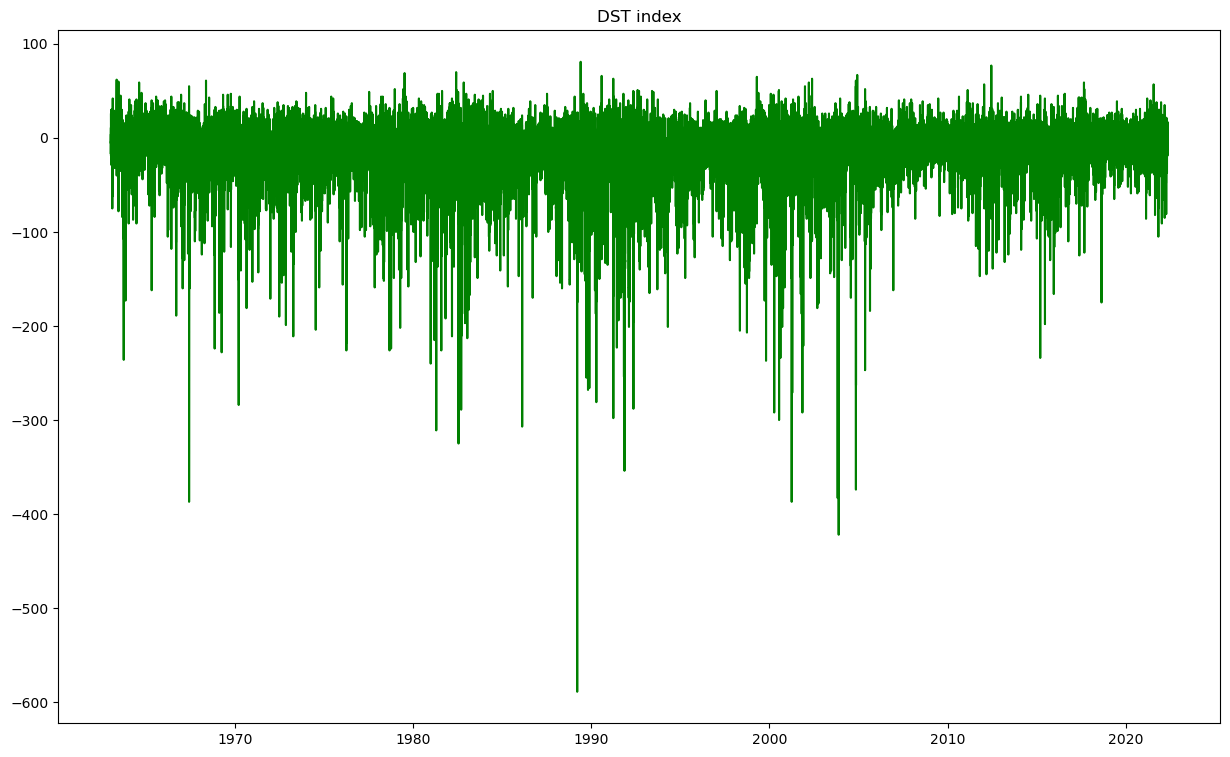

In [3]:
plt.rcParams['figure.figsize'] = [15, 9]
plt.figure()
plt.title("DST index")
plt.plot(train['time1'],train['DST'], color='green')
plt.plot(valid['time1'],valid['DST'], color='green')
plt.plot(test['time1'],test['DST'], color='green')

# Definovanie TimeseriesGenerator

In [4]:
n_input = 6  # koľko vzoriek/riadkov/časových krokov treba pozrieť do minulosti, aby bolo možné predpovedať ďalšiu vzorku
n_features= len(X_train) # koľko prediktorov/Xs/príznakov máme na predpovedanie y
b_size = 256  # počet vzoriek časových radov v každej dávke

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [5]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  1139
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [6]:
print("Počet batchov: ", len(test_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(test_generator[0]))
print("Dĺžka X zložky batchu: ", len(test_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(test_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(test_generator[0][0][0]))

Počet batchov:  610
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


In [7]:
print("Počet batchov: ", len(val_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(val_generator[0]))
print("Dĺžka X zložky batchu: ", len(val_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(val_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(val_generator[0][0][0]))

Počet batchov:  285
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


# Definovanie modelu a trénovanie

In [15]:
inputs = Input(shape=(6,1))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2024-05-07 20:03:05.622808: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           133120    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [16]:
# spätné volanie
saved_model = "model_6_1.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

In [17]:
# trenovanie
history = model.fit(train_generator, validation_data=val_generator, epochs=20, verbose=1, callbacks = callbacks_list)

Epoch 1/20
1138/1139 [============================>.] - ETA: 0s - loss: 140.7945 - mae: 5.5643
Epoch 1: val_mae improved from inf to 3.94160, saving model to model_6_1.hdf5
1139/1139 [==============================] - 38s 30ms/step - loss: 140.6969 - mae: 5.5628 - val_loss: 75.4751 - val_mae: 3.9416
Epoch 2/20
1138/1139 [============================>.] - ETA: 0s - loss: 51.3758 - mae: 3.9287
Epoch 2: val_mae improved from 3.94160 to 3.60876, saving model to model_6_1.hdf5
1139/1139 [==============================] - 34s 30ms/step - loss: 51.3440 - mae: 3.9278 - val_loss: 55.7774 - val_mae: 3.6088
Epoch 3/20
1138/1139 [============================>.] - ETA: 0s - loss: 37.0714 - mae: 3.5259
Epoch 3: val_mae improved from 3.60876 to 3.55013, saving model to model_6_1.hdf5
1139/1139 [==============================] - 34s 30ms/step - loss: 37.0539 - mae: 3.5254 - val_loss: 42.3555 - val_mae: 3.5501
Epoch 4/20
1138/1139 [============================>.] - ETA: 0s - loss: 37.5263 - mae: 3.5523

In [8]:
#načítanie natrénovaného modelu
model = keras.models.load_model('model_6_1.hdf5')

2024-05-16 10:27:57.991875: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# predikcie
y_pred = model.predict(test_generator)

610/610 [==============================] - 15s 24ms/step


In [10]:
y_pred

array([[13.176447 ],
       [12.859161 ],
       [ 9.243902 ],
       ...,
       [ 4.3313217],
       [ 4.8353105],
       [ 4.4735208]], dtype=float32)

# Nastavenie prahovej hodnoty a vyhodnotenie modelu

Confusion matrix: 
[[124372   1041]
 [  5641  25056]]


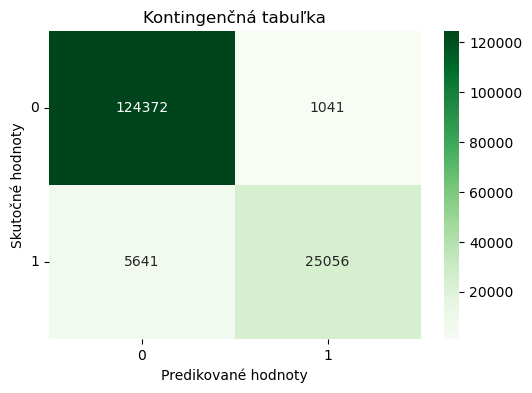

In [11]:
y_pred2 = np.where(y_pred <= -20, 1, 0)
y_test2 = np.where(y_test[n_input:] <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap='Greens')
plt.title('Kontingenčná tabuľka')
plt.xlabel('Predikované hodnoty')
plt.ylabel('Skutočné hodnoty')
plt.xticks(ticks=[0.5, 1.5], labels=['0', '1'])
plt.yticks(ticks=[0.5, 1.5], labels=['0', '1'], rotation=0)
plt.show()

In [12]:
print(classification_report(y_test2, y_pred2))

              precision    recall  f1-score   support

           0       0.96      0.99      0.97    125413
           1       0.96      0.82      0.88     30697

    accuracy                           0.96    156110
   macro avg       0.96      0.90      0.93    156110
weighted avg       0.96      0.96      0.96    156110



In [13]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

In [14]:
df

,time,y_true,y_predict
6,2004-07-22 03:00:00,14.0,13.176447
7,2004-07-22 04:00:00,11.0,12.859161
8,2004-07-22 05:00:00,11.0,9.243902
9,2004-07-22 06:00:00,9.0,10.598936
10,2004-07-22 07:00:00,8.0,7.528496
...,...,...,...
156111,2022-05-13 12:00:00,2.0,0.804517
156112,2022-05-13 13:00:00,4.0,2.146554
156113,2022-05-13 14:00:00,5.0,4.331322
156114,2022-05-13 15:00:00,5.0,4.835310


In [15]:
df.describe()

,y_true,y_predict
count,156110.000000,156110.000000
mean,-9.785055,-9.289316
std,16.323784,14.869319
min,-374.000000,-339.361603
25%,-16.000000,-15.531586
50%,-7.000000,-6.968997
75%,0.000000,-0.286968
max,77.000000,47.443142


<AxesSubplot:>

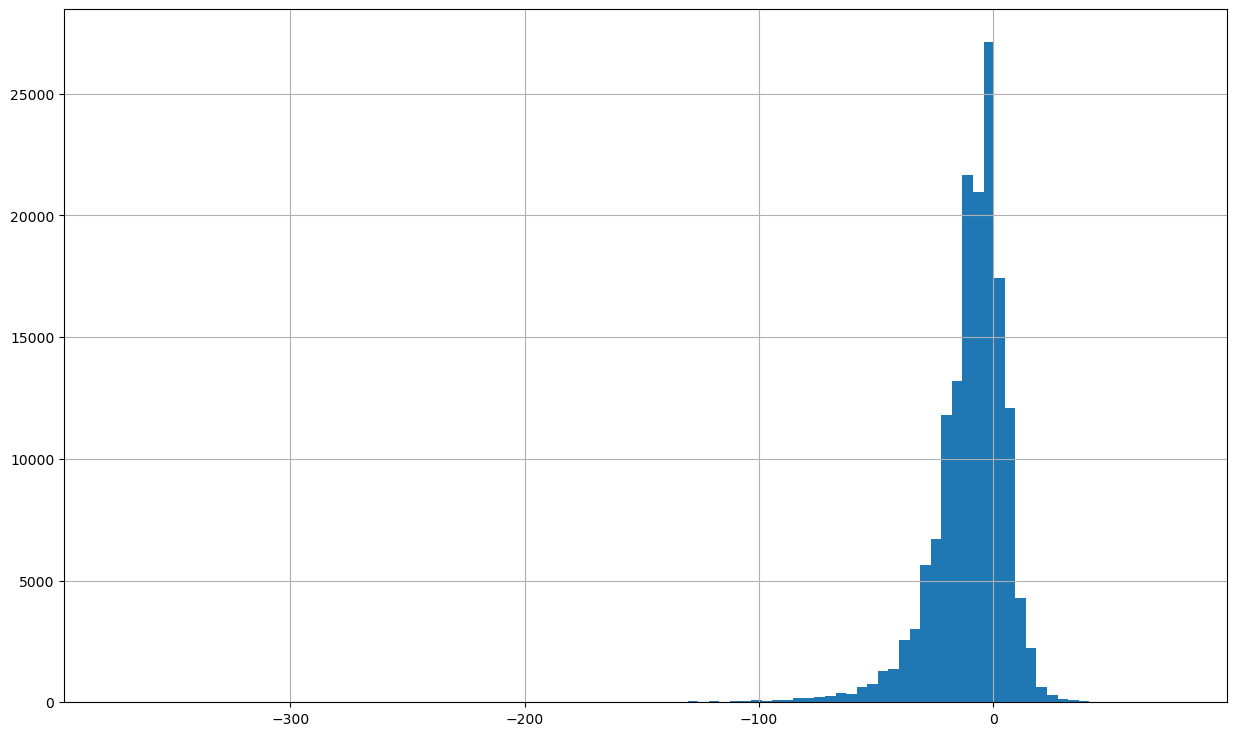

In [16]:
df["y_true"].hist(bins=100)

<AxesSubplot:>

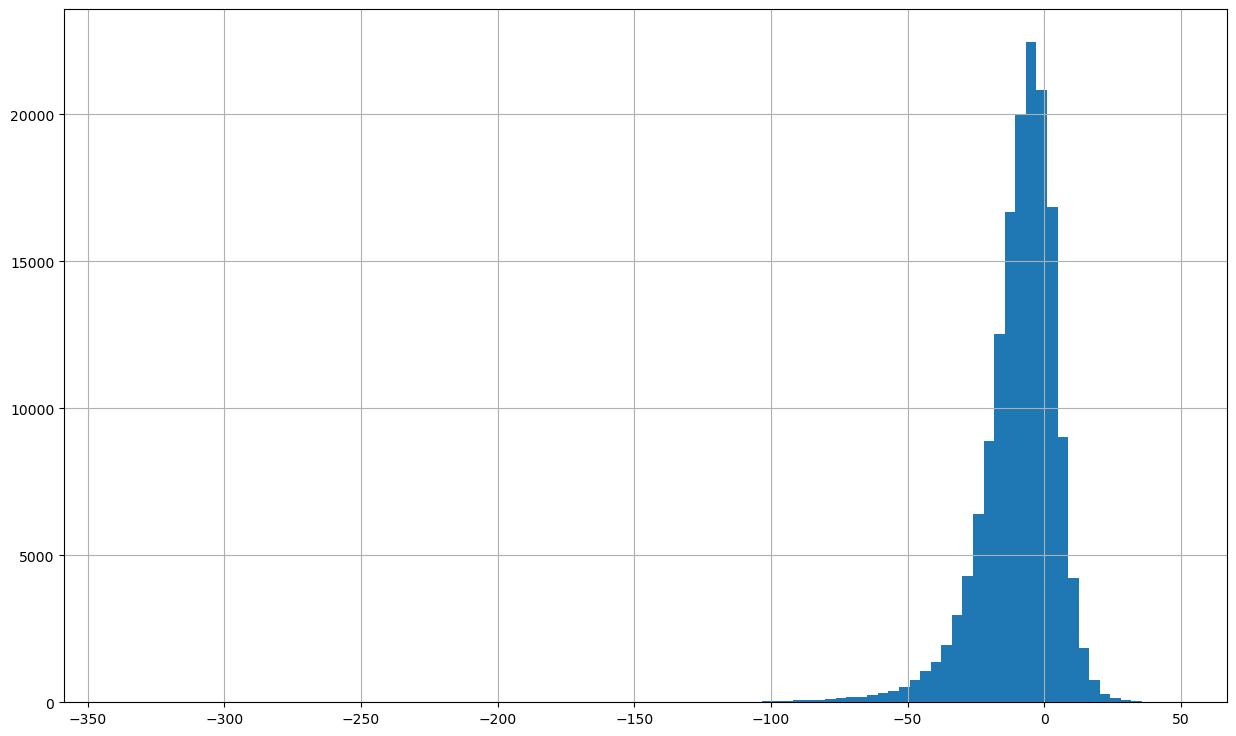

In [17]:
df["y_predict"].hist(bins=100)

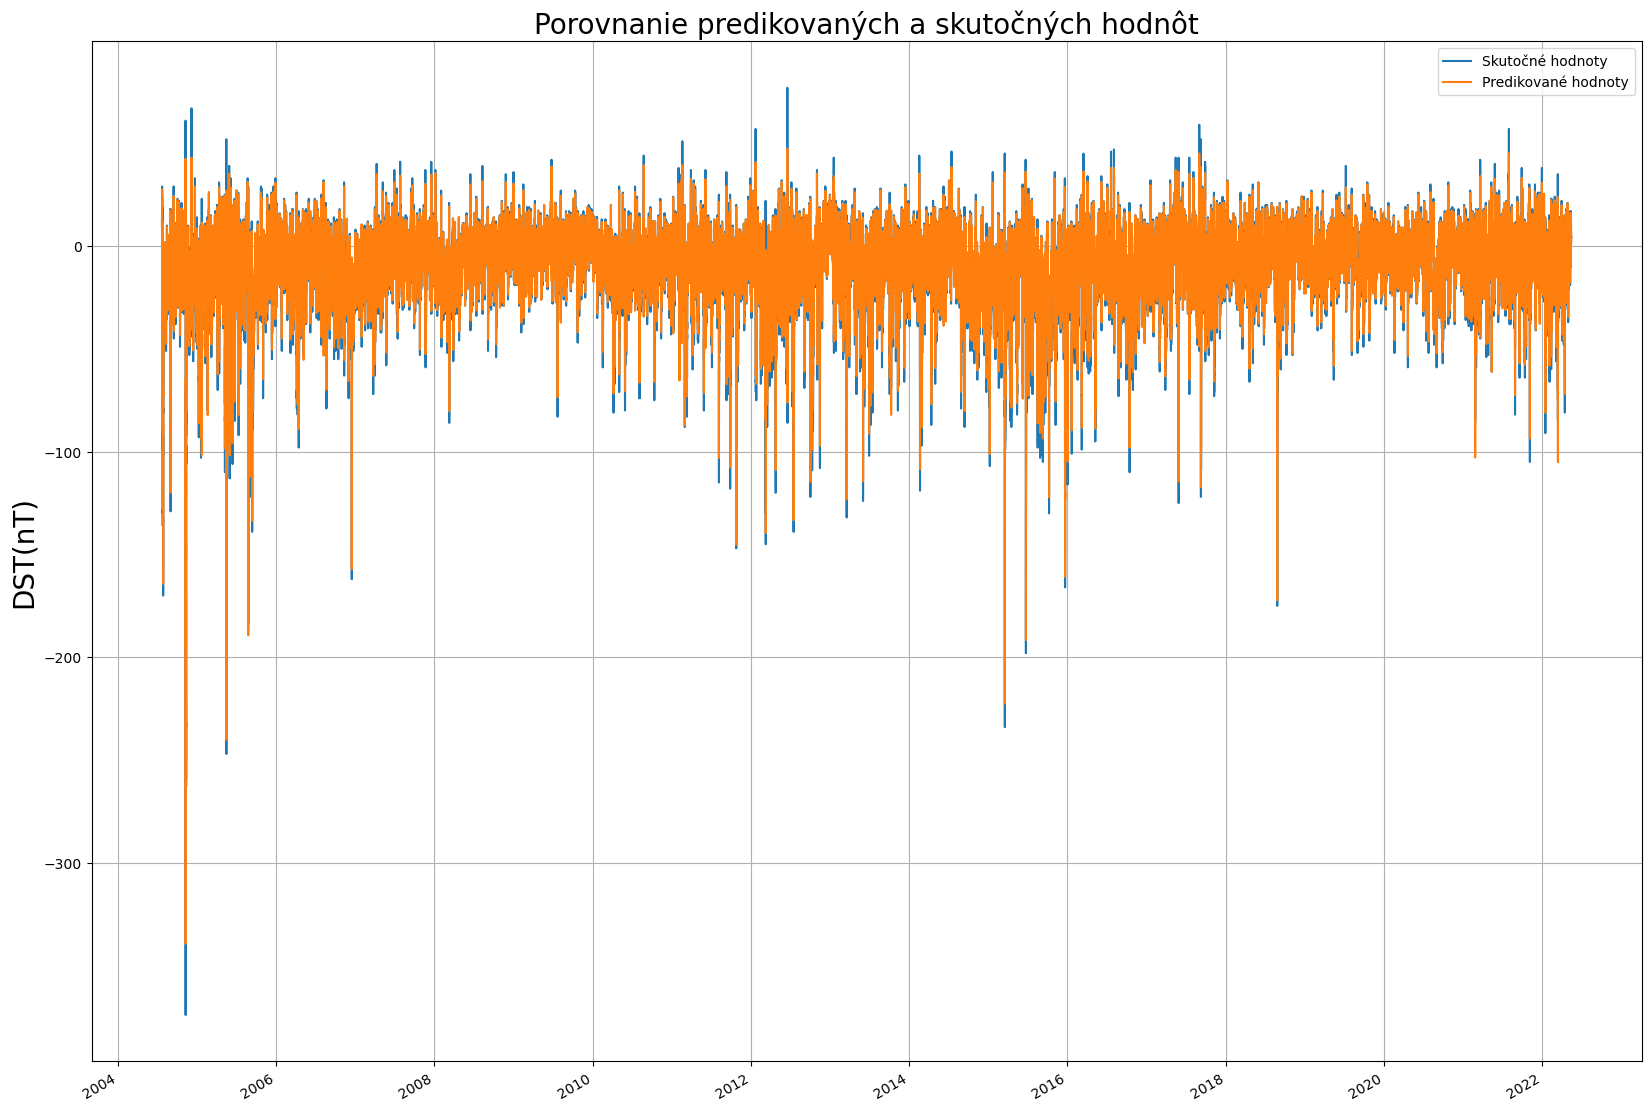

In [19]:
plt.figure(figsize=(20, 15))
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.ylabel('DST(nT)',fontsize=20)
plt.title('Porovnanie predikovaných a skutočných hodnôt',fontsize=20)
plt.gcf().autofmt_xdate()
plt.grid(True)

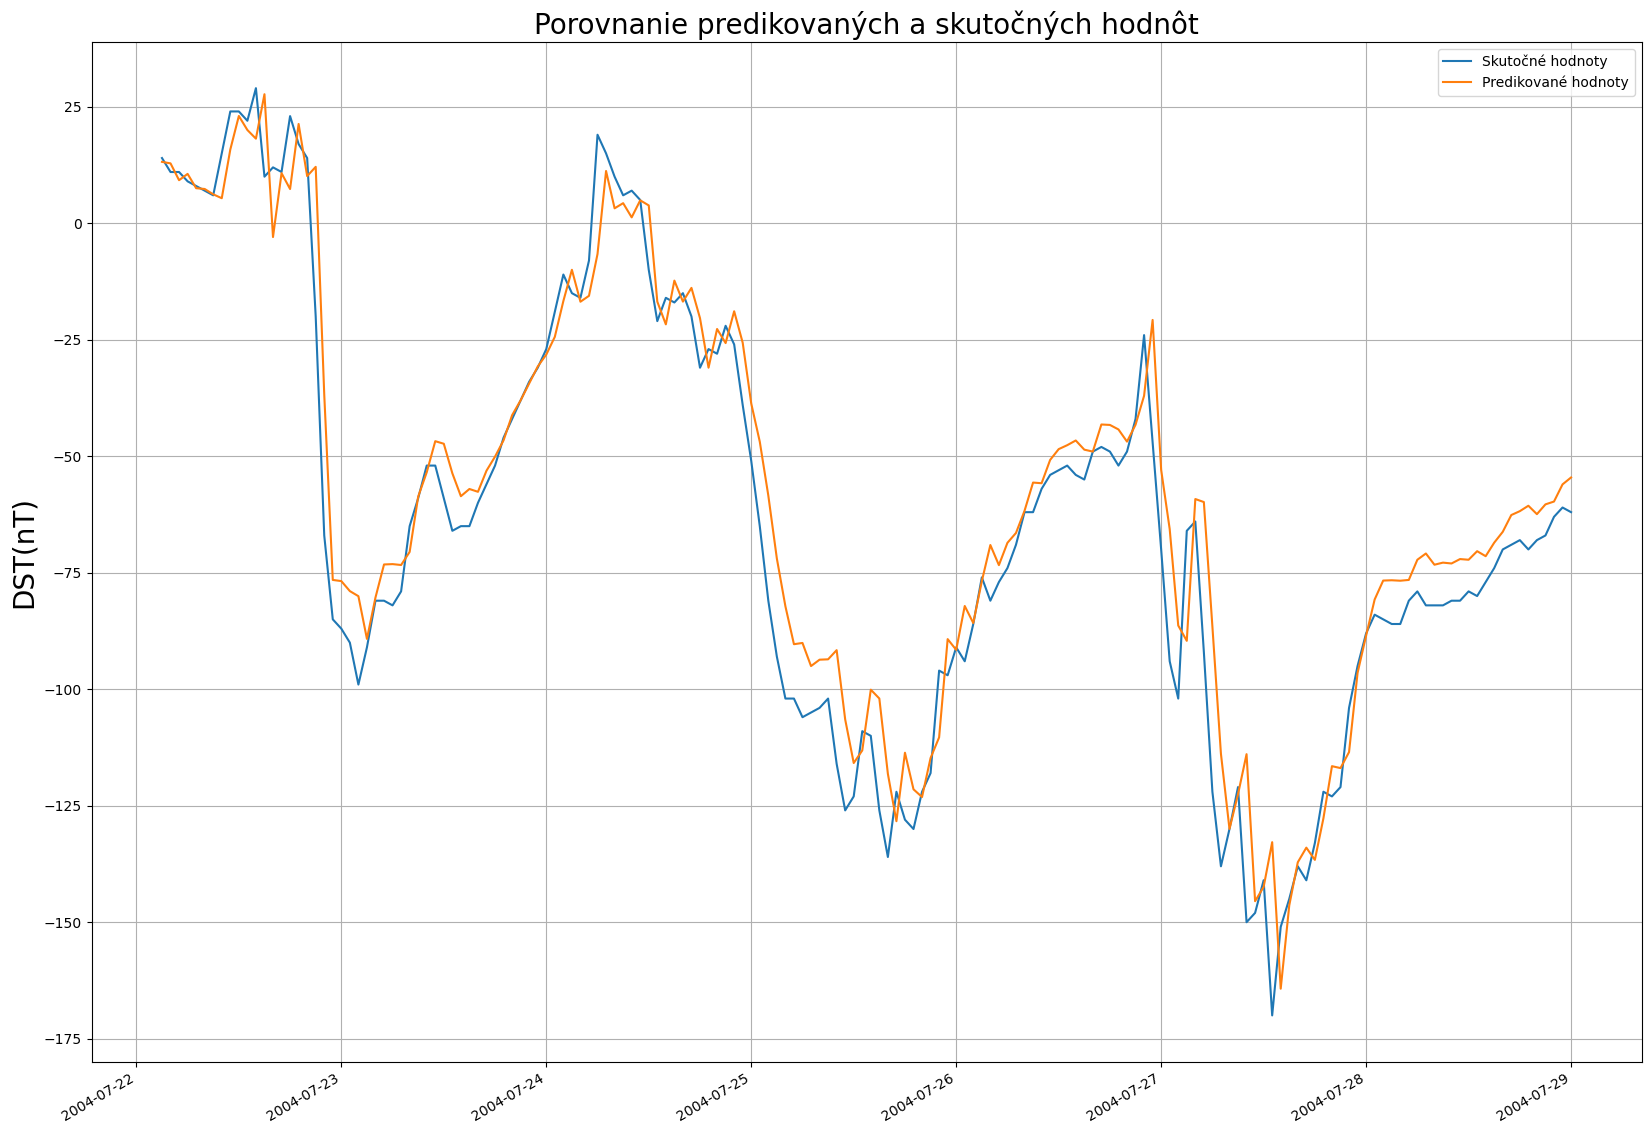

In [20]:
plt.figure(figsize=(20, 15))
data_subset = df.head(166)
plt.plot(data_subset['time'], data_subset['y_true'], label='Skutočné hodnoty')
plt.plot(data_subset['time'], data_subset['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.ylabel('DST(nT)',fontsize=20)
plt.title('Porovnanie predikovaných a skutočných hodnôt',fontsize=20)
plt.gcf().autofmt_xdate()
plt.grid(True)

In [20]:
df.to_csv('predikcie_6_1.csv')

# Vysvetliteľnosť modelu na základe DST indexu 6 h dozadu, predikcia súčasnej hodnoty

In [21]:
#import knižnic
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.lines import Line2D

In [22]:
#hodnota pre vypínanie intervalov priemer z testovacej mnoziny
value_for_shutdown = np.mean(X_test)
value_for_shutdown

-9.784205334494862

In [23]:
#hodnota pre vypínanie intervalov median z testovacej mnoziny
value_for_shutdown_median = np.median(X_test)
value_for_shutdown_median

-7.0

# Definovanie perturbačnej funkcie XAI

In [24]:
#povodna funkcia
def perturbation_method(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0,1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1- audio_scaled[i]
    audio_scaled1 = np.repeat(audio_scaled,interval_length)
    
    # Vizualizácia
    dst = data_instance

    time_data = np.arange(-6,0)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst[0:n_input],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+1, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='red', alpha=0.8)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='orange', alpha=1)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='yellow', alpha=0.3)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.85) & (audio_scaled1[0:n_input] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.6) & (audio_scaled1[0:n_input] <= 0.85), color='orange', alpha=1)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.5) & (audio_scaled1[0:n_input] <= 0.6), color='yellow', alpha=0.3)
    
    plt.close(fig)
    return fig

In [25]:
#upravena funkcia podla vysledkov z dotaznika
def perturbation_method(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0,1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1- audio_scaled[i]
    audio_scaled1 = np.repeat(audio_scaled,interval_length)
    
    # Vizualizácia
    dst = data_instance

    time_data = np.arange(-6,0)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst[0:n_input],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+1, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i],time_data[i],  color='red', alpha=1, linewidth=10.0)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i], color='orange', alpha=1, linewidth=10.0)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i], color='yellow', alpha=1, linewidth=10.0)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.85) & (audio_scaled1[0:n_input] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.6) & (audio_scaled1[0:n_input] <= 0.85), color='orange', alpha=1)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input] > 0.5) & (audio_scaled1[0:n_input] <= 0.6), color='yellow', alpha=0.3)
    
    plt.close(fig)
    return fig


In [26]:
# povodna funkcia 
def perturbation_method_with_predicted_value(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0, 1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1 - audio_scaled[i]
    # audio_scaled1 = np.repeat(audio_scaled,interval_length)
    audio_scaled1 = np.concatenate([np.repeat(audio_scaled, interval_length), np.zeros(1),np.zeros(1)])

    # Vizualizácia
    dst = data_instance
    dst_new = np.append(dst,y_pred_single)
    dst_new = np.append(dst_new,y_pred_single)
    
    
    time_data = np.arange(-6,2)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst_new[0:n_input+2],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+2, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4),
                    Line2D([0], [0], color='green', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='red', alpha=0.8)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='orange', alpha=1)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i]+1, color='yellow', alpha=0.3)


    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.85) & (audio_scaled1[0:n_input+1] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.6) & (audio_scaled1[0:n_input+1] <= 0.85), color='orange', alpha=1)
    plt.fill_betweenx([ymin, ymax], time_data[6], time_data[6]+1, color='green', alpha=0.3)
    
    
    plt.close(fig)
    return fig

In [27]:
#upravena funkcia podla vysledkov z dotaznika
def perturbation_method_with_predicted_value(data_instance, model, interval_length, value_for_shutdown):
    testovacia_vzorka = data_instance.reshape(1,n_input,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
        
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0, 1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1 - audio_scaled[i]
    # audio_scaled1 = np.repeat(audio_scaled,interval_length)
    audio_scaled1 = np.concatenate([np.repeat(audio_scaled, interval_length), np.zeros(1)])

    # Vizualizácia
    dst = data_instance
    dst_new = np.append(dst,y_pred_single)
    dst_new = np.append(dst_new,y_pred_single)
    
    
    time_data = np.arange(-6,1)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst_new[0:n_input+1],color='black')
    plt.title("Vysvetliteľnosť indexu DST"+" (dlžka perturbovaného intervalu je "+str(interval_length)+")", fontsize=24)
    plt.xlabel("Časový priebeh (h)", fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(0, n_input+1, 1)
    ax.set_xticks(grid_x_ticks , minor=True)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4),
                    Line2D([0], [0], color='green', lw=4)]
    
    ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 20)
    
    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i],time_data[i],  color='red', alpha=1, linewidth=10.0)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i], color='orange', alpha=1, linewidth=10.0)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i], color='yellow', alpha=1, linewidth=10.0)
   


    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.85) & (audio_scaled1[0:n_input+1] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.6) & (audio_scaled1[0:n_input+1] <= 0.85), color='orange', alpha=1)
    plt.fill_betweenx([ymin, ymax], time_data[6], time_data[6], color='green', alpha=0.8, linewidth=10.0)
    
    
    plt.close(fig)
    return fig

1/1 [==============================] - 0s 30ms/step


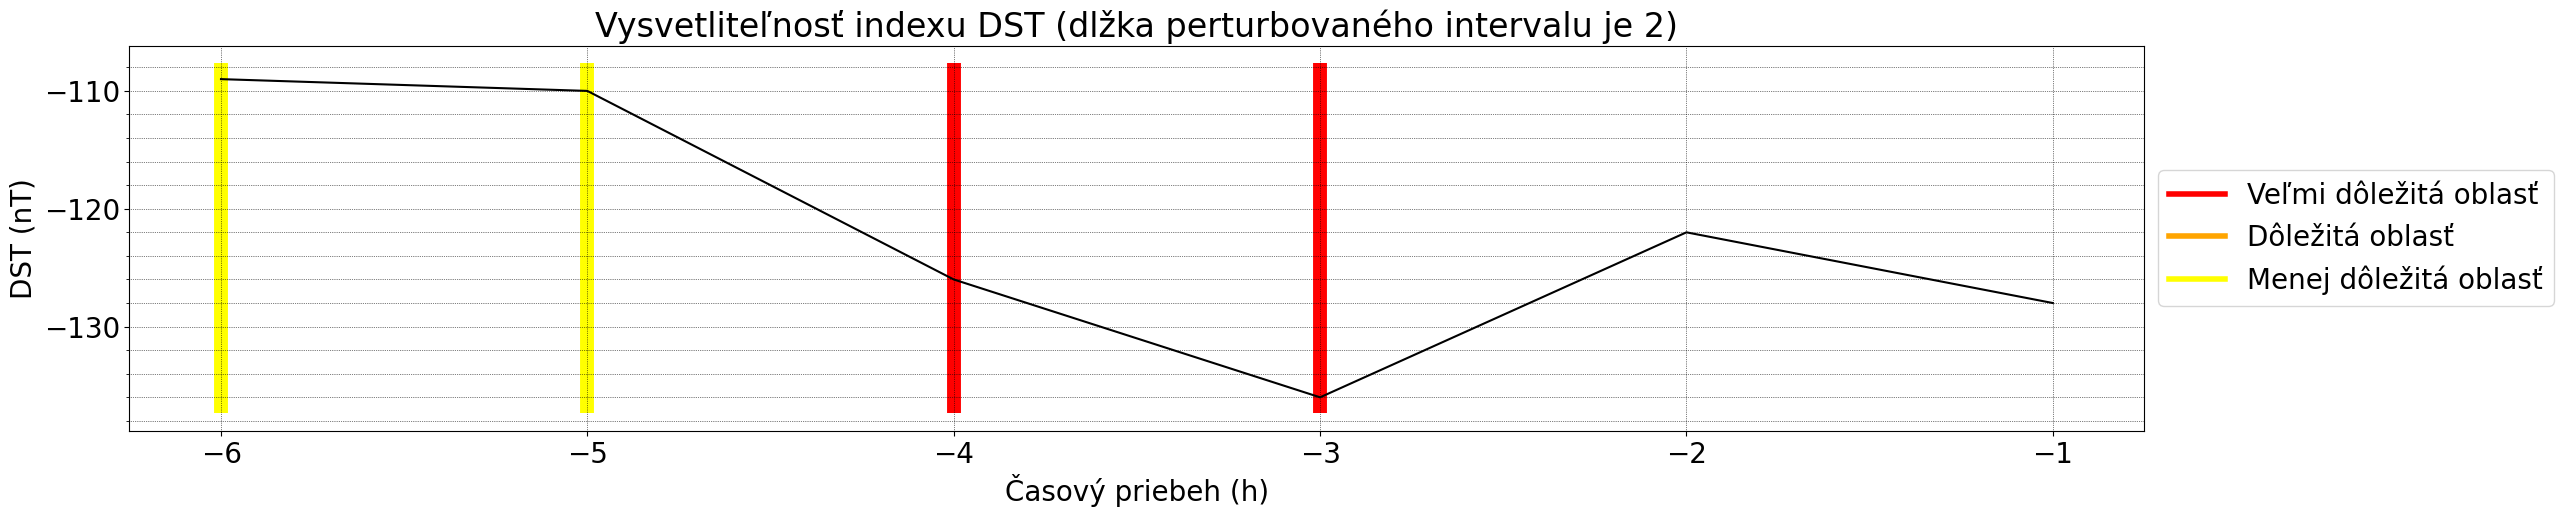

In [28]:
perturbation_method(test_generator[0][0][88], model,2, value_for_shutdown)

1/1 [==============================] - 0s 26ms/step


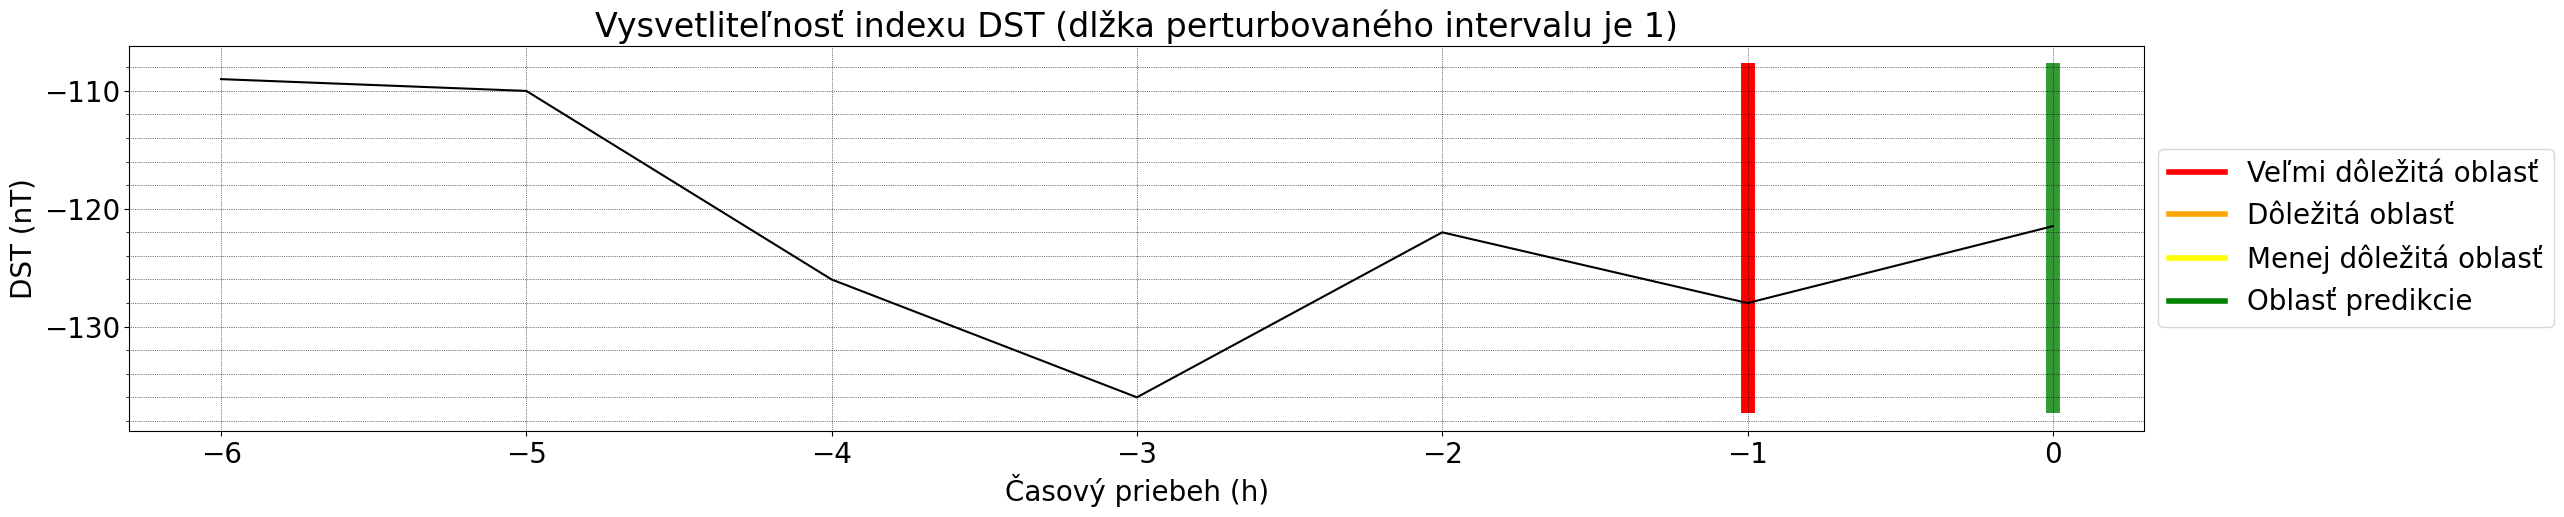

In [31]:
perturbation_method_with_predicted_value(test_generator[0][0][88], model,1, value_for_shutdown)

1/1 [==============================] - 0s 32ms/step


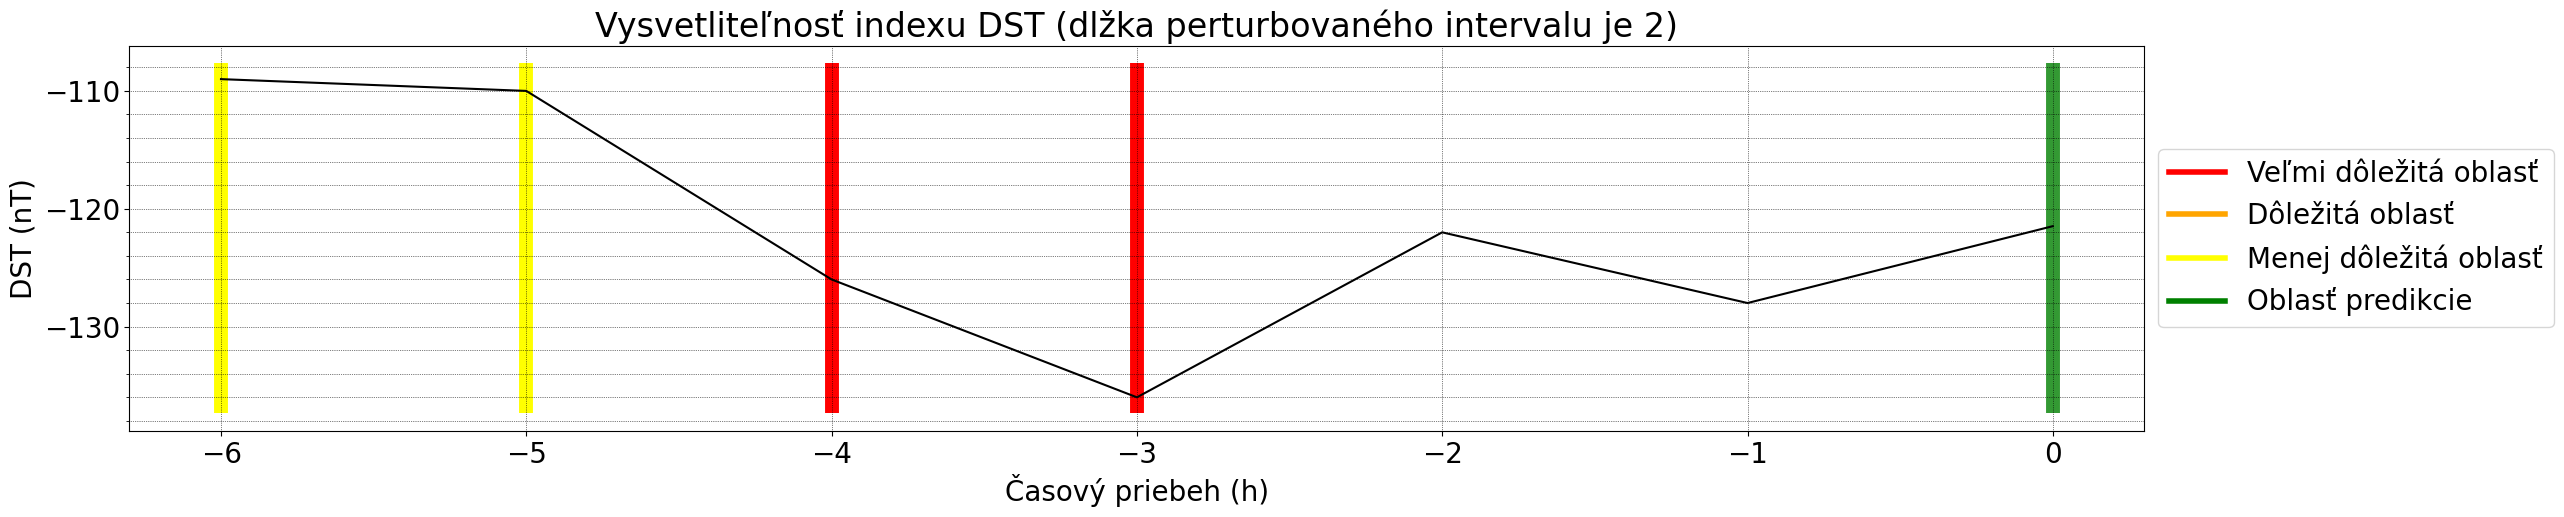

In [32]:
perturbation_method_with_predicted_value(test_generator[0][0][88], model,2, value_for_shutdown)

# Vizualizácia (dashboard)

In [33]:
#upravena funkcia podla vysledkov z dotaznika
# funkcia pre vizualizáciu
def perturbation_method_with_predicted_value_for_dashboard(data_instance,data_instance2, model, interval_length, value_for_shutdown,max_range):
    testovacia_vzorka = data_instance.reshape(1,6,1)
    y_pred_single = model.predict(testovacia_vzorka)
    
    number_of_intervals = n_input // interval_length
    importance_of_intervals = []
    for i in range(number_of_intervals):
        perturbovana_vzorka = np.zeros_like(testovacia_vzorka)
        perturbovana_vzorka[:] = testovacia_vzorka[:]
    
        perturbovana_vzorka[0][i*interval_length:(i+1)*interval_length][0] = value_for_shutdown
        nova_predikcia = model.predict(perturbovana_vzorka)
        importance = y_pred_single[0][0] - nova_predikcia[0][0]
        importance_of_intervals.append(importance)
 
    audio_scaled = minmax_scale(importance_of_intervals, feature_range=(0, 1))
    for i in range(number_of_intervals):
        audio_scaled[i] = 1 - audio_scaled[i]

    audio_scaled1 = np.concatenate([np.repeat(audio_scaled, interval_length), np.zeros(1),np.zeros(1)])

    
    # Vizualizácia
    if np.any(data_instance2 != 0):
        dst = data_instance
        dst_new = np.append(dst,data_instance2[-1])
        dst_new = np.append(dst_new,data_instance2[-1])
    else:
        dst = data_instance
        dst_new = np.append(dst,y_pred_single)
        dst_new = np.append(dst_new,y_pred_single)

    time_data = np.arange(7)
    fig = plt.figure(figsize=(26,5))
    
    plt.plot(time_data, dst_new[0:7],color='black')
    plt.xlabel("Časový priebeh (h)",fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    
    ax = plt.subplot(111)
    plt.minorticks_on()
    grid_x_ticks = np.arange(max_range - 7, max_range+1, 1) % 24
    ax.set_xticks(grid_x_ticks , minor=True)
    ax.set_xticklabels(grid_x_ticks)
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    custom_lines = [Line2D([0], [0], color= 'red', lw=4),
                    Line2D([0], [0], color='orange', lw=4),
                    Line2D([0], [0], color='yellow', lw=4),
                    Line2D([0], [0], color='green', lw=4)]
    if np.any(data_instance2 != 0):
        ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Skutočná oblasť'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)
    else:
        ax.legend(custom_lines,['Veľmi dôležitá oblasť', 'Dôležitá oblasť', 'Menej dôležitá oblasť','Oblasť predikcie'],loc='center left', bbox_to_anchor=(1, 0.5), fontsize=20)

    ymin, ymax = plt.ylim()
    for i in range(len(audio_scaled1)):
        if audio_scaled1[i] > 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i],time_data[i],  color='red', alpha=1, linewidth=10.0)
        elif 0.6 < audio_scaled1[i] <= 0.85:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i], color='orange', alpha=1, linewidth=10.0)
        elif 0.5 < audio_scaled1[i] <= 0.6:
            plt.fill_betweenx([ymin, ymax], time_data[i], time_data[i], color='yellow', alpha=1, linewidth=10.0)
   


    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.85) & (audio_scaled1[0:n_input+1] <= 1) , color='red', alpha=0.8)
    #plt.fill_between(time_data, ymin, ymax, where= (audio_scaled1[0:n_input+1] > 0.6) & (audio_scaled1[0:n_input+1] <= 0.85), color='orange', alpha=1)
    plt.fill_betweenx([ymin, ymax], time_data[6], time_data[6], color='green', alpha=0.8,linewidth=10.0)
    
    
    plt.close(fig)
    return fig

# Dashboard zobrazuje reálne a predikované hodnoty DST a taktiež doležitosť intervalov na predikciu súčasnej hodnoty

In [34]:
# import knižníc
import ipywidgets as widgets
from ipywidgets import IntSlider, Layout
from IPython.display import display, clear_output
from IPython.display import display, HTML
import datetime

In [35]:
# pred spustením je potrebné postupne spustiť kazdý riadok, trénovanie modelu nie je nutné, stači model načíatať

In [36]:
# vizualizácia (dashboard)
dashboard_title = widgets.HTML(value="<h1 style='color: green; text-align: left;'>Vysetliteľnosť modelu na predikciu indexu DST</h1>")
style_html = """
<style>
    .widget-label { font-size: 16px; }
</style>
"""

sequences = []
for x, y in test_generator:
    sequences.extend(x)
    
y_pred = model.predict(test_generator)
    
style = {'description_width': 'initial'}

start_date_widget = widgets.DatePicker(
    description='Zvoľ si dátum sledovania:',
    disabled=False,
    style=style,
    value=datetime.date(2004, 7, 22),
    min=datetime.date(2004, 7, 22),
    max=datetime.date(2022, 5, 14)
)
hours_to_watch_widget = widgets.IntSlider(value=12, min=0, max=24, description='Koľko hodín chceš sledovať:', step=1, style=style)
hours_to_watch_widget.layout = Layout(width='350px', height='40px')
interval_length_widget = widgets.RadioButtons(options=[1, 2, 3],description='Výber dĺžky perturbovaného intervalu:',value=2,disabled=False, style=style)
index_widget = widgets.IntSlider(value=12,description='Výber konkrétnej hodiny počas dňa:', continuous_update=False,min=0,max=24, style=style)        
index_widget.layout = Layout(width='400px', height='40px')

generate_button1 = widgets.Button(description='Generovať graf', button_style='success')
generate_button2 = widgets.Button(description='Generovať graf', button_style='success')

output_container1 = widgets.Output()
output_container2 = widgets.Output()

def on_generate_button_clicked1(b):
    
    selected_date = start_date_widget.value
    start_index = (selected_date - datetime.date(2004, 7, 22)).days    
    start_index = max(0, start_index) 
    index = index_widget.value
    interval_length = interval_length_widget.value
    hours_to_watch = hours_to_watch_widget.value
    
    if start_index == 0:
        start_index = start_index*24
        fig1 = perturbation_method_with_predicted_value_for_dashboard(sequences[start_index+index-3],0, model, interval_length, value_for_shutdown,index)
        fig1.suptitle('Vybrané časové okno s predikovanou hodnotou',fontsize = 24)
        fig2 = perturbation_method_with_predicted_value_for_dashboard(sequences[start_index+index-3],sequences[start_index+index-3+1], model, interval_length, value_for_shutdown,index)
        fig2.suptitle('Vybrané časové okno so skutočnou hodnotou', fontsize = 24)
    else:
        start_index = (start_index*24)-3
        fig1 = perturbation_method_with_predicted_value_for_dashboard(sequences[start_index+index],0, model, interval_length, value_for_shutdown,index)
        fig1.suptitle('Vybrané časové okno s predikovanou hodnotou', fontsize = 24)
        fig2 = perturbation_method_with_predicted_value_for_dashboard(sequences[start_index+index],sequences[start_index+index+1], model, interval_length, value_for_shutdown,index)
        fig2.suptitle('Vybrané časové okno so skutočnou hodnotou', fontsize = 24)
    
    with output_container1:
        clear_output(wait=True)
        display(fig2)
        display(fig1)
        
def on_generate_button_clicked2(b):

    selected_date = start_date_widget.value
    start_index = (selected_date - datetime.date(2004, 7, 22)).days    
    start_index = max(0, start_index) 
    hours_to_watch = hours_to_watch_widget.value
    last_elements = []
    elements = []
    start_index2 = 0
    start_index1 = 0
    hours_to_watch1 = hours_to_watch
    hours_to_watch2 = hours_to_watch
    
    if start_index == 0:
        hours_to_watch1 = 22
        start_index1 = 1
    elif start_index == 6504:
        start_index1 = (start_index*24)-2
        hours_to_watch1 = 16
    else:
        start_index1 = (start_index*24)-2
    
    for i in range(start_index1,start_index1+hours_to_watch1):
        last_elements.append(sequences[i][-1])

    fig3 = plt.figure(figsize=(26, 3))
    if start_index == 0:
        plt.plot(range(3, 3 + len(last_elements)), last_elements, marker='o', c='green')
        plt.xticks(range(3, 3 + hours_to_watch1))
    else:
        plt.plot(last_elements, marker='o', c='green')
        plt.xticks(range(hours_to_watch1)) 
        
    plt.title('Skutošné hodnoty DST na ' + str(hours_to_watch1) + "-hodinovom okne",fontsize=25)
    plt.xlabel("Časový priebeh (h)",fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.yticks(fontsize=15)
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    
    if start_index == 0:
        start_index2 = 0
        hours_to_watch2 = 22
    elif start_index == 6504:
        start_index2 = (start_index*24)-3
        hours_to_watch2 = 17
    else:
        start_index2 = (start_index*24)-3
    
    for i in range(start_index2,start_index2+hours_to_watch2):
        elements.append(y_pred[i])
    
    fig4 = plt.figure(figsize=(26, 3))
    if start_index == 0:
        plt.plot(range(3, 3 + len(elements)), elements, marker='o', c='green')
        plt.xticks(range(3, 3 + hours_to_watch2))
    else:
        plt.plot(elements, marker='o', c='green')
        plt.xticks(range(hours_to_watch2))
    
    plt.title('Predikované hodnoty DST na '+ str(hours_to_watch2)+ "-hodinovom okne", fontsize=25)
    plt.xlabel("Časový priebeh (h)",fontsize=20)
    plt.ylabel("DST (nT)", fontsize=20)
    plt.tick_params(axis='x', labelsize=20)
    plt.yticks(fontsize=15)
    plt.grid(which='minor', linestyle=':', color='black', linewidth='0.5')
    plt.grid(which='major', linestyle=':', color='black', linewidth='0.5')
    
    
    with output_container2:
        clear_output(wait=True)
        display(fig4)
        display(fig3)

generate_button1.on_click(on_generate_button_clicked1)
generate_button2.on_click(on_generate_button_clicked2)

display(HTML(style_html), dashboard_title, start_date_widget, hours_to_watch_widget, generate_button2, output_container2, index_widget,interval_length_widget,generate_button1,output_container1)

610/610 [==============================] - 14s 23ms/step


HTML(value="<h1 style='color: green; text-align: left;'>Vysetliteľnosť modelu na predikciu indexu DST</h1>")

DatePicker(value=datetime.date(2004, 7, 22), description='Zvoľ si dátum sledovania:', max=datetime.date(2022, …

IntSlider(value=12, description='Koľko hodín chceš sledovať:', layout=Layout(height='40px', width='350px'), ma…

Button(button_style='success', description='Generovať graf', style=ButtonStyle())

Output()

IntSlider(value=12, continuous_update=False, description='Výber konkrétnej hodiny počas dňa:', layout=Layout(h…

RadioButtons(description='Výber dĺžky perturbovaného intervalu:', index=1, options=(1, 2, 3), style=Descriptio…

Button(button_style='success', description='Generovať graf', style=ButtonStyle())

Output()

# Dôležité dni kedy DST kleslo pod hodnotu -150

In [37]:
important_dates = []

for index, row in df.iterrows():
    if row['y_true'] < -150:
        date = pd.to_datetime(row['time']).date()
        important_dates.append(date)

important_dates = list(set(important_dates))

print(important_dates)

[datetime.date(2004, 7, 27), datetime.date(2005, 8, 24), datetime.date(2004, 11, 10), datetime.date(2005, 5, 15), datetime.date(2006, 12, 15), datetime.date(2015, 3, 18), datetime.date(2015, 12, 21), datetime.date(2004, 11, 9), datetime.date(2015, 3, 17), datetime.date(2004, 11, 8), datetime.date(2018, 8, 26), datetime.date(2015, 6, 23), datetime.date(2015, 12, 20)]


# Analýza pred dotazníkom

In [38]:
sequence = []
for x, y in test_generator:
    sequence.extend(x)

In [39]:
len(sequence)

156110

In [40]:
before_2012 = df[df['time'].dt.year < 2012]
after_2017 = df[df['time'].dt.year <= 2017]

count1 = before_2012.shape[0]
count2 = after_2017.shape[0]
count1


65253

In [41]:
count2

117861

In [42]:
import os

In [50]:
# vytvorenie pričinku ak neexistuje
image_direction1 = "grafy_analyza_6_1"
os.makedirs(image_direction1, exist_ok=True)

In [ ]:
path = os.path.join(image_direction1, "grafy_analyza_perturb1_test_6_1")
os.makedirs(folder_path, exist_ok=True)

for i in range(65254, 117861):
    if abs(sequence[i][5] - sequence[i][0]) >= 50:
        over_the_border = any(x >= -20 for x in sequence[i])
        below_the_border = any(x < -20 for x in sequence[i])

        if over_the_border and below_the_border:
            fig = perturbation_method_with_predicted_value(sequence[i], model, 1, value_for_shutdown)
            file_path = os.path.join(path, f"image_{i}.jpg") 
            fig.savefig(path, dpi=50, bbox_inches='tight') 
            #fig.savefig(file_path)
            plt.close(fig)

# Dodatočná analýza po výsledkoch dotazníka

In [ ]:
#predikovana hodnota lok.minimom
for i in range(0, 156109):
    if sequence[i][0] - sequence[i][5] >= 50 and sequence[i][0] > sequence[i][-1]:
        over_the_border = any(x >= -20 for x in sequence[i])
        below_the_border = any(x < -20 for x in sequence[i])
        if over_the_border and below_the_border:
            if i + 1 < len(sequence):
                predicted_value = model.predict(sequence[i].reshape(1,n_input,1))
                if all(predicted_value.flatten() < sequence[i]):
                    print(sequence[i],i)  

In [68]:
# vymazanie priečinku
import shutil
shutil.rmtree(image_direction9, ignore_errors=True)

In [473]:
# vytvorenie pričinku ak neexistuje
image_direction9 = "analyza_perturb_test_6_1_lok_minimum_2004_2022"
os.makedirs(image_direction9, exist_ok=True)

In [ ]:
#predikovana hodnota lok.minimom 2004-2022 (ukladanie ako jeden spolocny obrazok)
from PIL import Image
import numpy as np

images = []

for i in range(0, 156109):
    if sequence[i][0] - sequence[i][5] >= 50 and sequence[i][0] > sequence[i][-1]:
        over_the_border = any(x >= -20 for x in sequence[i])
        below_the_border = any(x < -20 for x in sequence[i])
        if over_the_border and below_the_border:
            if i + 1 < len(sequence):
                predicted_value = model.predict(sequence[i].reshape(1, n_input, 1))
                if all(predicted_value.flatten() < sequence[i]):
                    fig = perturbation_method_with_predicted_value(sequence[i], model, 3, value_for_shutdown)
                    fig.canvas.draw()
                    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
                    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                    images.append(data)
                    plt.close(fig)

output_image = Image.fromarray(np.concatenate(images, axis=0))

output_image.save(os.path.join(image_direction9, "grafy_perturb3.jpg"))

In [ ]:
#predikovana hodnota lok.minimom 2004-2022 (ukladanie samostatne)

path = os.path.join(image_direction9, "grafy_perturb3")
os.makedirs(path, exist_ok=True)

for i in range(0, 156109):
    if sequence[i][0] - sequence[i][5] >= 50 and sequence[i][0] > sequence[i][-1]:
        over_the_border = any(x >= -20 for x in sequence[i])
        below_the_border = any(x < -20 for x in sequence[i])
        if over_the_border and below_the_border:
            if i + 1 < len(sequence):
                predicted_value = model.predict(sequence[i].reshape(1,n_input,1))
                if all(predicted_value.flatten() < sequence[i]):
                    fig = perturbation_method_with_predicted_value(sequence[i], model, 3, value_for_shutdown)
                    file_path = os.path.join(path, f"image_{i}.jpg") 
                    fig.savefig(file_path, dpi=50, bbox_inches='tight') 
                    plt.close(fig)

In [40]:
# vytvorenie pričinku ak neexistuje
image_direction10 = "analyza_perturb_test_6_1_lok_minimum_2004_2022_priemerna_lok_hodnota"
os.makedirs(image_direction10, exist_ok=True)

In [ ]:
#predikovana hodnota lok.minimom 2004-2022 s preimernou lokalnou hodnotou vypinania (ukladanie ako jeden spolocny obrazok)
from PIL import Image
import numpy as np

images = []

for i in range(0, 156109):
    if sequence[i][0] - sequence[i][5] >= 50 and sequence[i][0] > sequence[i][-1]:
        over_the_border = any(x >= -20 for x in sequence[i])
        below_the_border = any(x < -20 for x in sequence[i])
        if over_the_border and below_the_border:
            if i + 1 < len(sequence):
                predicted_value = model.predict(sequence[i].reshape(1, n_input, 1))
                if all(predicted_value.flatten() < sequence[i]):
                    fig = perturbation_method_with_predicted_value(sequence[i], model, 3, np.mean(sequence[i]))
                    fig.canvas.draw()
                    data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
                    data = data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
                    images.append(data)
                    plt.close(fig)

output_image = Image.fromarray(np.concatenate(images, axis=0))

output_image.save(os.path.join(image_direction10, "grafy_perturb3.jpg"))

In [ ]:
#predikovana hodnota lok.minimom 2004-2022 s preimernou lokalnou hodnotou vypinania (ukladanie samostatne)

path = os.path.join(image_direction10, "grafy_perturb3")
os.makedirs(folder_path, exist_ok=True)

for i in range(0, 156109):
    if sequence[i][0] - sequence[i][5] >= 50 and sequence[i][0] > sequence[i][-1]:
        over_the_border = any(x >= -20 for x in sequence[i])
        below_the_border = any(x < -20 for x in sequence[i])
        if over_the_border and below_the_border:
            if i + 1 < len(sequence):
                predicted_value = model.predict(sequence[i].reshape(1,n_input,1))
                if all(predicted_value.flatten() < sequence[i]):
                    fig = perturbation_method_with_predicted_value(sequence[i], model, 3, np.mean(sequence[i]))
                    file_path = os.path.join(path, f"image_{i}.jpg") 
                    fig.savefig(file_path, dpi=50, bbox_inches='tight') 
                    plt.close(fig)

In [ ]:
perturbation_method_with_predicted_value(test_generator[0][0][88], model,2, value_for_shutdown)

1/1 [==============================] - 0s 27ms/step


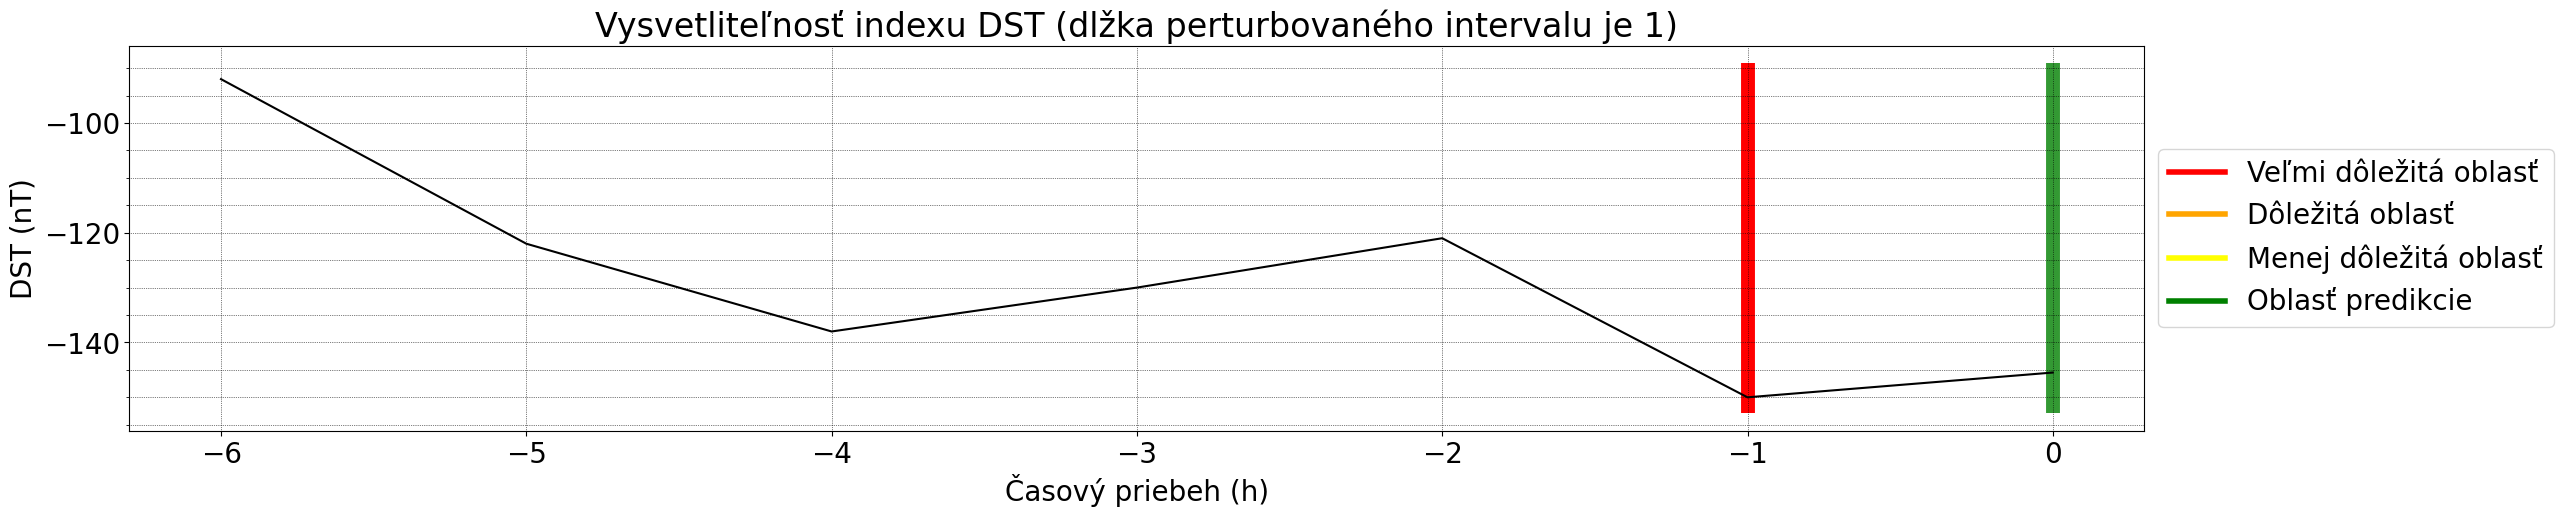

In [88]:
perturbation_method_with_predicted_value(test_generator[0][0][128], model,1, value_for_shutdown)

1/1 [==============================] - 0s 26ms/step


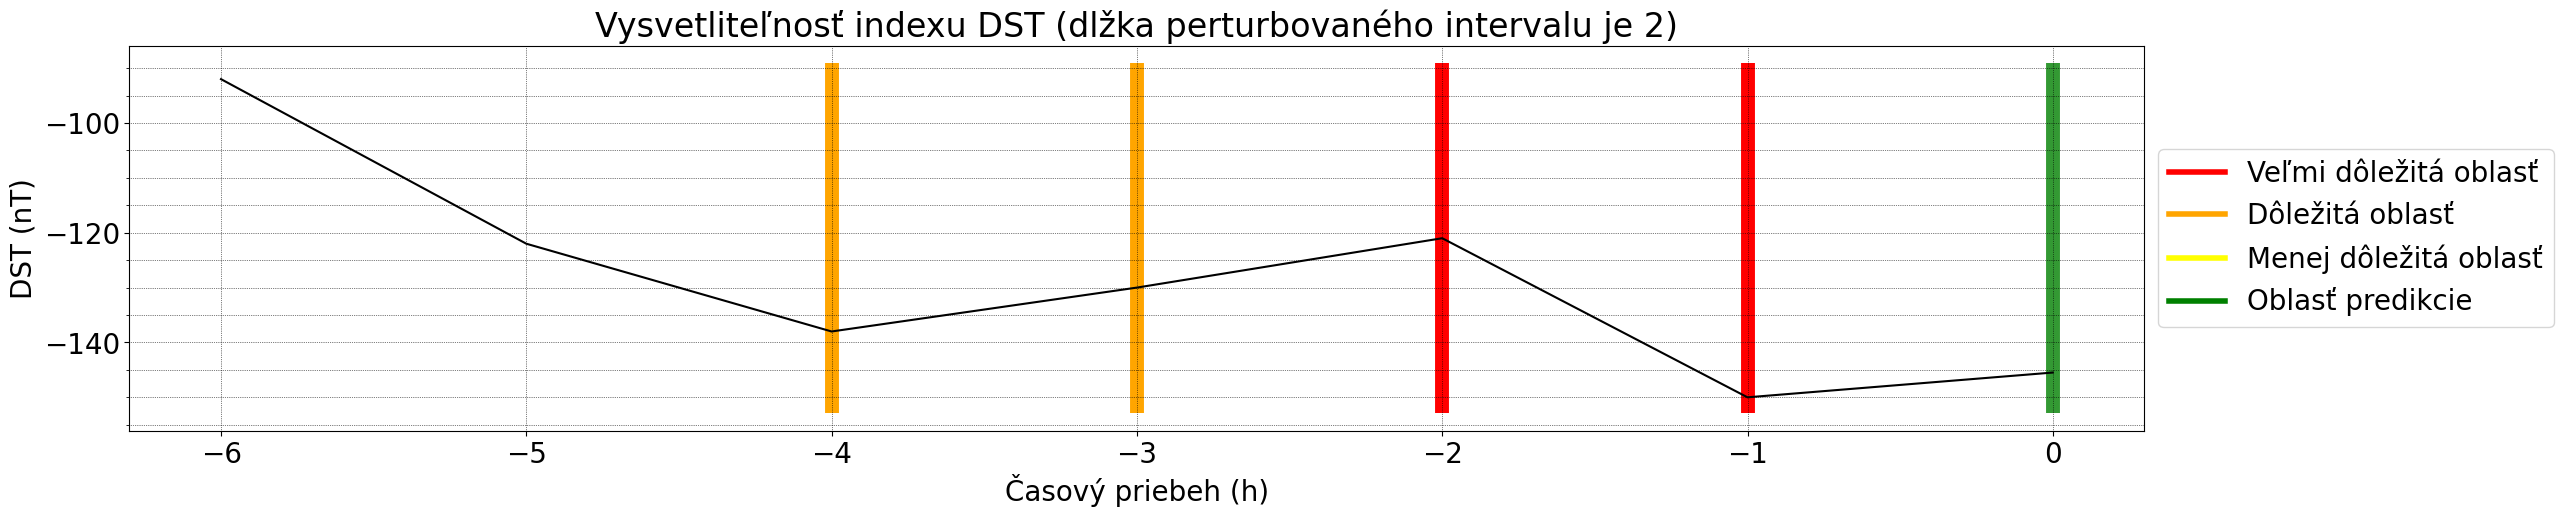

In [90]:
perturbation_method_with_predicted_value(test_generator[0][0][128], model,2, value_for_shutdown)

1/1 [==============================] - 0s 23ms/step


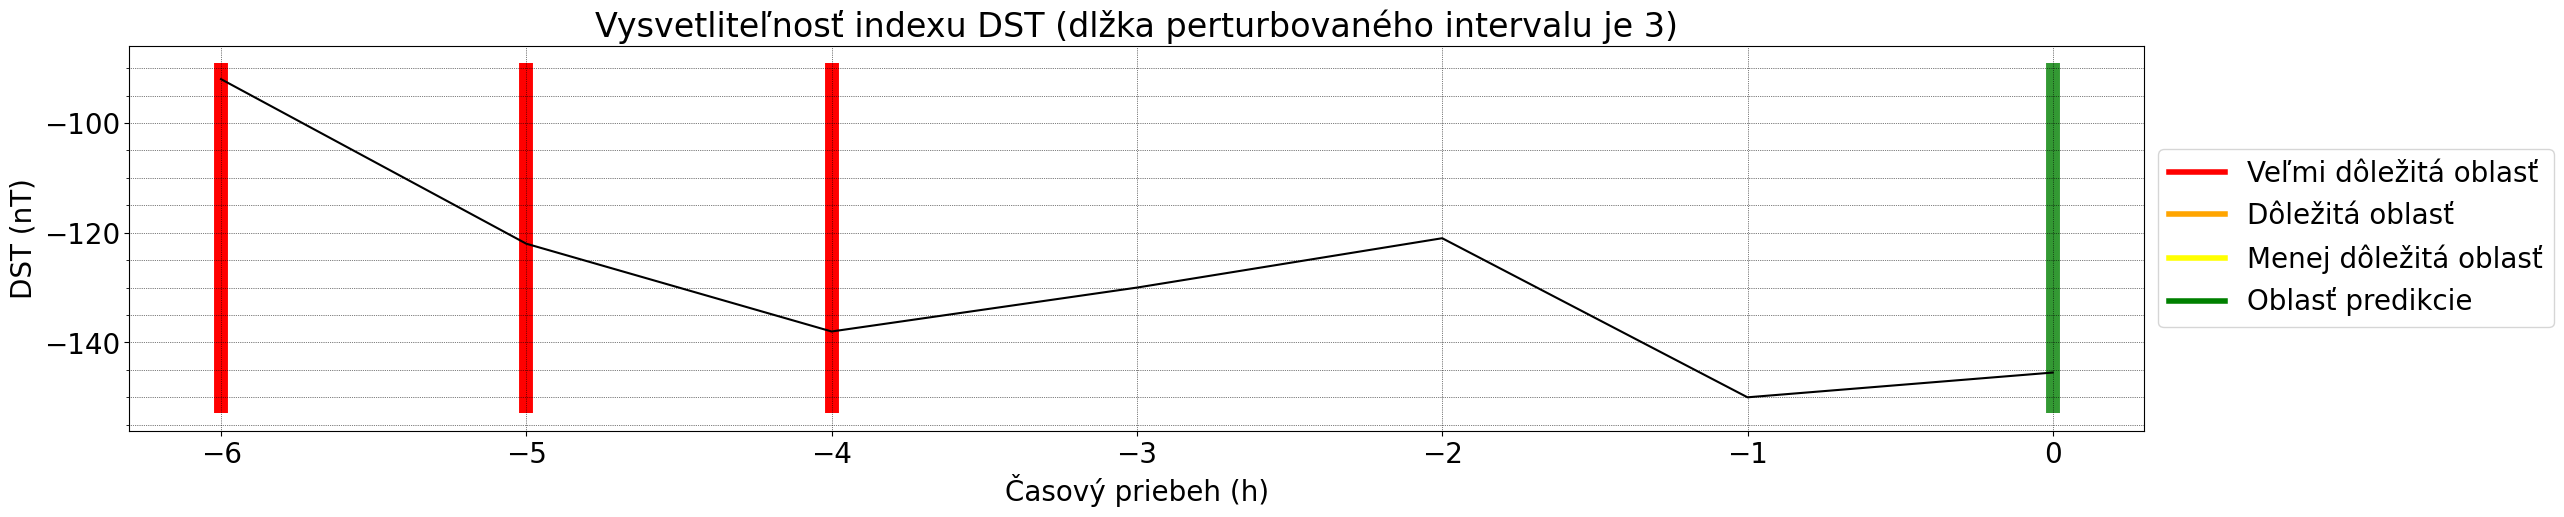

In [91]:
perturbation_method_with_predicted_value(test_generator[0][0][128], model,3, value_for_shutdown)